<a href="https://colab.research.google.com/github/j-c-stuifbergen/machine-learning-for-physicists/blob/master/04_homework_ImageRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Recognition (with keras)

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

Session 4: Homework for lecture 3

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook shows how to:
- recognize images (softmax, cross-entropy), using dense layers



### Imports: numpy and matplotlib and keras

In [346]:
# keras: Sequential is the neural-network class, Dense is
# the standard network layer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers # to choose more advanced optimizers like 'adam'

from tqdm import tqdm # progress bar

import numpy as np

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display

# for updating display 
# (very simple animation)
from IPython.display import clear_output
from time import sleep

# Telling Lorentzians from Gaussians, Sines and Gaborians!

In [347]:
def Lorentzian(Amplitude = 1, width = 1, x0 = 0):
    def function(x):
      return Amplitude / ((( x-x0)/width)**2+1)
    return function
    
def Gaussian(Amplitude = 1, width = 1, x0 = 0):
    def function(x):
      return Amplitude * np.exp(-(( x-x0)/width)**2)
    return function
      
def Sine(Amplitude = 1, width = 1, x0 = 0):
    def function(x):
      return Amplitude * np.sin(( x-x0)/width)
    return function
      
def Gabor(Amplitude = 1, width = 1, x0 = 0):
    def function(x):
      return Sine(Amplitude,width,x0)(x)*Gaussian(Amplitude,width,x0)(x)
    return function
      
params_Lorentz = {"func": Lorentzian, "name": "L"}
params_Gauss = {"func": Gaussian, "name": "Gau"}
params_Sine = {"func": Sine, "name": "Sin"}
params_Gabor = {"func": Gabor, "name": "bor"}

functions = [ params_Lorentz, params_Gauss]
functions = [ params_Gabor, params_Gauss]
functions = [ params_Sine, params_Gauss]
functions = [ params_Gabor, params_Sine]
functions = [ params_Gabor, params_Sine, params_Gauss]
functions = [ params_Gabor, params_Sine, params_Lorentz, params_Gauss]


N=100 # number of pixels in 'image'

Net=Sequential()
Net.add(Dense(30,input_shape=(N,), activation="relu"))
Net.add(Dense(20,activation="relu"))
Net.add(Dense(len(functions),activation="softmax"))

Net.compile(loss='categorical_crossentropy', 
            optimizer='adam', 
            metrics=['categorical_accuracy'])


In [348]:

def my_generator1D(batchsize,x): # produce a batch of curves, randomly Lorentzian or Gaussian
    
    R=np.random.uniform(size=batchsize) # width
    A=np.random.uniform(size=batchsize) # amplitude
    x0=np.random.uniform(size=batchsize,low=-1,high=1) # position

    nCat = len(functions)
    names = []
    # choose random numbers from {0,1,2,... ,nCat-1}
    categories = np.floor(np.random.uniform(0,nCat,size=batchsize)).astype(int)
    resultLayer=np.zeros([batchsize,nCat])
    inputLayer=np.zeros([batchsize,len(x)])
    for j in range(nCat):
      names.append (functions[j]["name"])
      resultLayer[:,j]= (categories == j) # becomes 1 if category == j
      inputLayer += resultLayer[:,j][:,None]*functions[j]["func"](A[:,None], R[:,None], x0[:,None])(x)

    return( inputLayer, resultLayer, names )

# my_generator1D(5,np.linspace(-1,1,8))     # test


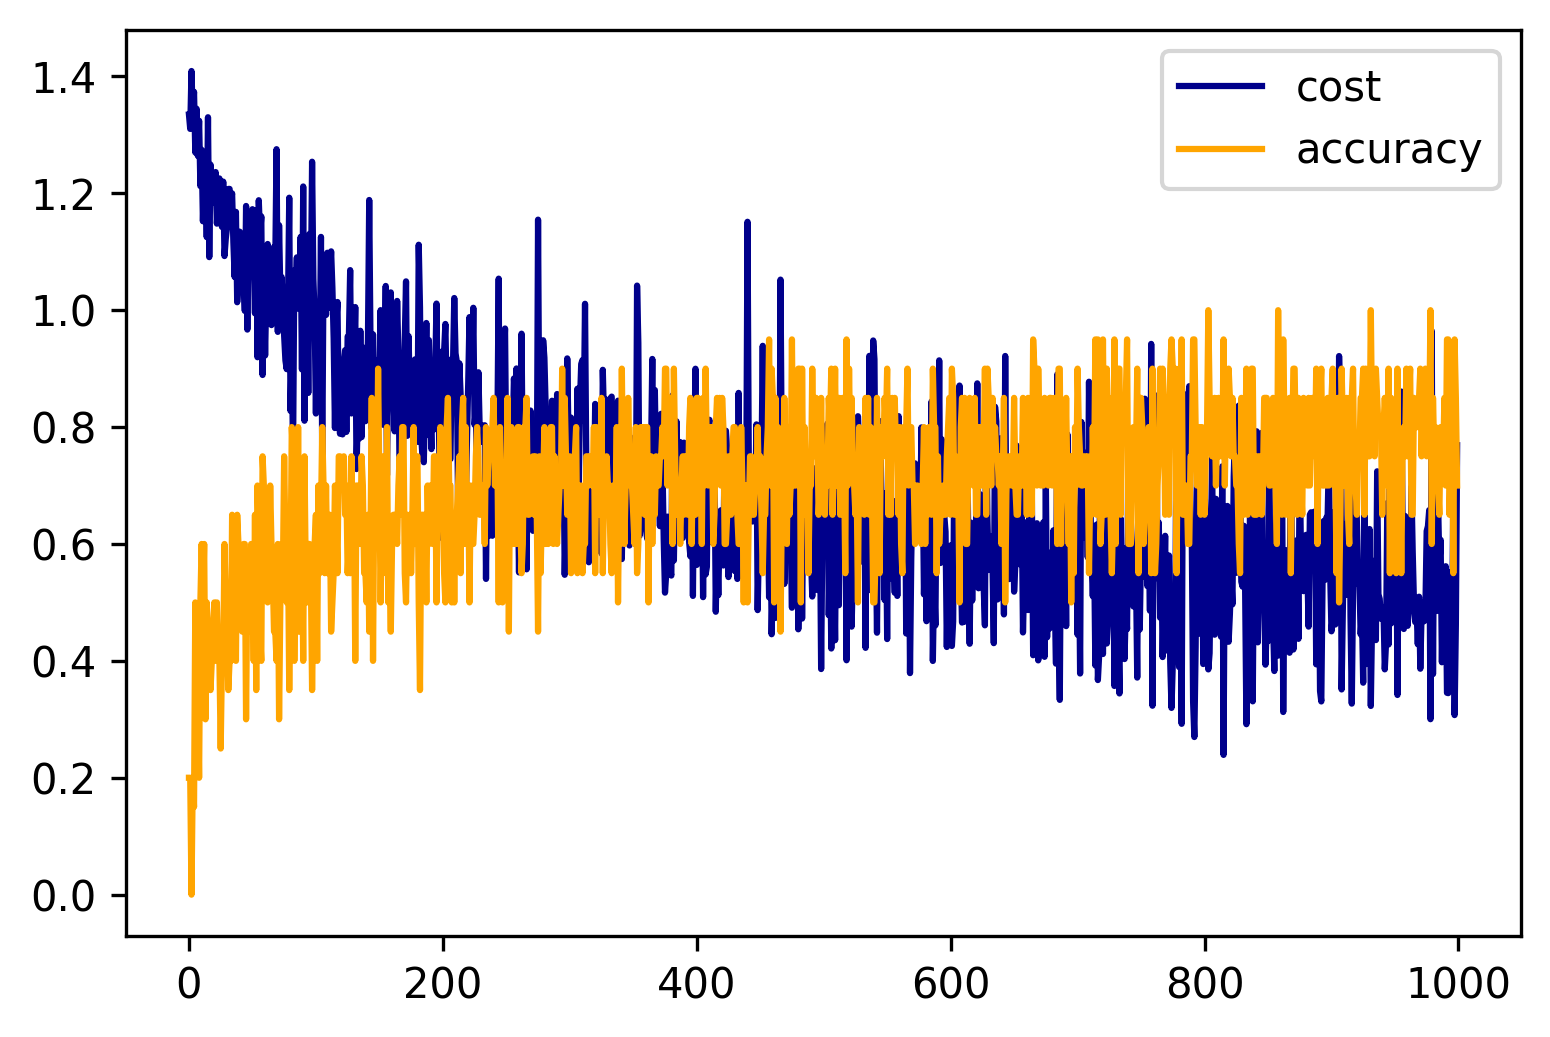

In [349]:
batchsize=20
steps=1000

x=np.linspace(-1,1,N)
costs=np.zeros(steps)
accuracy=np.zeros(steps)
skipsteps=10
names = [] # will be generated by my_generator1D

for j in range(steps):
    y_in,y_target,names=my_generator1D(batchsize,x)
    costs[j],accuracy[j]=Net.train_on_batch(y_in,y_target)
    if j%skipsteps==0 or j==steps-1:
        clear_output(wait=True)
        plt.plot(costs,color="darkblue",label="cost")
        plt.plot(accuracy,color="orange",label="accuracy")
        plt.legend()
        plt.show()

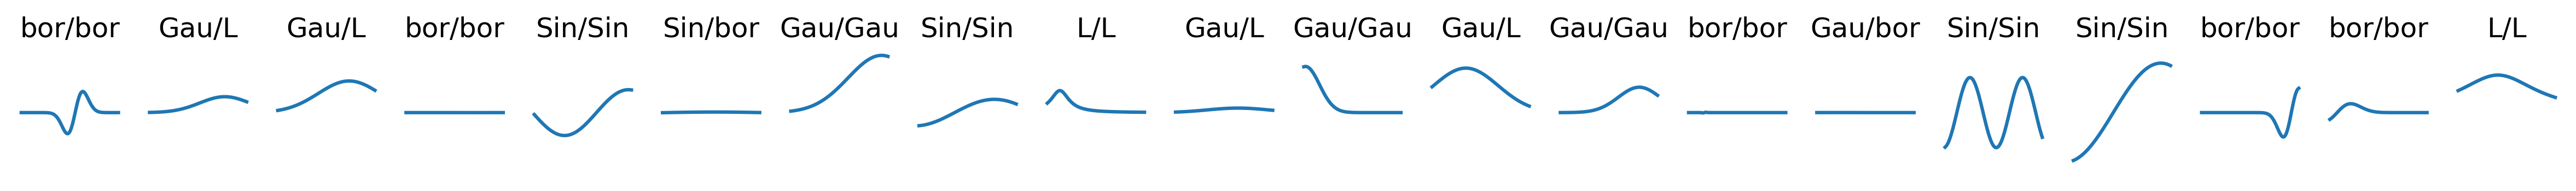

True Category / Network Prediction


In [352]:
# plot some examples:

y_pred=Net.predict_on_batch(y_in)
n_samples=20
fig,ax=plt.subplots(ncols=n_samples,nrows=1,figsize=(n_samples,1))
Name={}
Name[True]="L" # Lorentz
Name[False]="G" # Gauss
for j in range(n_samples):
    ax[j].plot(y_in[j,:])
    ax[j].set_ylim([-1,1])
    ax[j].axis('off')
    ax[j].set_title(Name[y_target[j,0]>0.5]+"/"+Name[y_pred[j,0]>0.5])
    ax[j].set_title(names[np.argmax(y_target[j,:])]+"/"+names[np.argmax(y_pred[j,:])])
plt.show()
    
print("True Category / Network Prediction")


# Random circles or squares

In [ ]:
# produce random circles or squares in 2D

def my_generator2D(batchsize,x,y):
    R=np.random.uniform(low=0.2,high=1,size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-0.8,high=0.8)
    y0=np.random.uniform(size=batchsize,low=-0.8,high=0.8)
    IsCircle=(np.random.uniform(size=batchsize)<0.5)*1.0 # Circle? (==1) or Square?
    Circles=1.0*((x[None,:]-x0[:,None])**2 + (y[None,:]-y0[:,None])**2 < R[:,None]**2)
    Squares=1.0*(np.abs(x[None,:]-x0[:,None])<R[:,None])*(np.abs(y[None,:]-y0[:,None])<R[:,None])
    inputLayer=IsCircle[:,None]*Circles + (1-IsCircle[:,None])*Squares
    resultLayer=np.zeros([batchsize,2])
    resultLayer[:,0]=IsCircle
    resultLayer[:,1]=1-IsCircle
    return( inputLayer, resultLayer  )



In [ ]:
N=20 # number of pixels in 'image'

Net=Sequential()
Net.add(Dense(30,input_shape=(N**2,), activation="relu"))
Net.add(Dense(20,activation="relu"))
Net.add(Dense(2,activation="softmax"))

Net.compile(loss='categorical_crossentropy', 
            optimizer='adam', 
            metrics=['categorical_accuracy'])



In [ ]:
batchsize=20
steps=1000

vals=np.linspace(-1,1,N)
X,Y=np.meshgrid(vals,vals)
x,y=X.flatten(),Y.flatten() # make 1D arrays, as needed for dense layers!

costs=np.zeros(steps)
accuracy=np.zeros(steps)
skipsteps=10

for j in range(steps):
    y_in,y_target=my_generator2D(batchsize,x,y)
    costs[j],accuracy[j]=Net.train_on_batch(y_in,y_target)
    if j%skipsteps==0 or j==steps-1:
        clear_output(wait=True)
        plt.plot(costs,color="darkblue",label="cost")
        plt.plot(accuracy,color="orange",label="accuracy")
        plt.legend()
        plt.show()

In [ ]:
# plot some examples:

y_pred=Net.predict_on_batch(y_in)
n_samples=10
fig,ax=plt.subplots(ncols=n_samples,nrows=1,figsize=(10,1))
Name={}
Name[True]="C" # Circle
Name[False]="S" # Square
for j in range(n_samples):
    ax[j].imshow(np.reshape(y_in[j,:],[N,N]),origin='lower')
    ax[j].axis('off')
    ax[j].set_title(Name[y_target[j,0]>0.5]+"/"+Name[y_pred[j,0]>0.5])
plt.show()
    
print("True Category / Network Prediction")
